In [50]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
from langdetect import detect
import time
import numpy as np
import pandas as pd
from pandas_ml import ConfusionMatrix
import seaborn

import sklearn as sk
from sklearn.model_selection import train_test_split
import numpy as np
import json

import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import pickle

import matplotlib.pyplot as plt
import random
import nltk, re, time
from nltk.corpus import stopwords
import string
from collections import defaultdict
from collections import namedtuple
from contractions import get_contractions

import operator
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import tensor_array_ops
print('TensorFlow Version: {}'.format(tf.__version__))
import os 
alreadyPickled = False

TensorFlow Version: 1.5.0


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
embedding_dim = 300
num_layers = 2
num_classes = 6
epochs = 5
batch_size = 64
rnn_size = 64
num_layers = 2

learning_rate = 0.005

keep_probability = 0.8
max_sequence_length = 750

IS_TRAINING = True
IS_TESTING = False

In [5]:
def picklefiles(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def loadfiles(filename):
    saved_stuff = open(filename,"rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff

In [6]:
def clean_text(text):
    text = text.lower()    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [7]:
restId = []
for line in open('./data/dataset/business.json', 'r'):
    data = json.loads(line)
    if 'Restaurants' in data['categories'] or 'Food' in data['categories']:
        restId.append(data['business_id'])
print("There are %d restaurants" % (len(restId)))

There are 69047 restaurants


In [ ]:
contractions = get_contractions()

revs_list = [[]]
stars_list = [[]]
num = 1000000
k = 0
nolang = [[]]
for line in open('./data/dataset/review.json', 'r', encoding='utf-8'):
    if k >= num:
        break
    data = json.loads(line)
    text = data['text']
    star = data['stars']
    ID = data['business_id']
    if text == None:
        continue
    if star == None:
        continue
    if ID not in restId:
        continue
    try:
        if detect(text) == 'en':
            revs_list.append(clean_text(text))
            stars_list.append(star)
            k += 1
            if len(revs_list) % 5000 == 0:
                print(len(revs_list), k)
    except:
        nolang.append(text)

In [9]:
print(revs_list[1])
print(len(revs_list), len(stars_list))

love staff love meat love place prepare long line around lunch dinner hours ask want meat lean something maybe cannot remember say want fatty get half sour pickle hot pepper hand cut french fries
1000001 1000001


In [11]:
np_revs = np.asarray([revs_list]).T
np_stars = np.asarray([stars_list]).T
stacked_revs = np.hstack((np_revs, np_stars))
categories = ['text', 'stars']
print(np_revs.shape, np_stars.shape, stacked_revs.shape)
df_reviews_processing = pd.DataFrame(stacked_revs, columns=categories)
print(df_reviews_processing.shape)
print(df_reviews_processing.head())

(1000001, 1) (1000001, 1) (1000001, 2)
(1000001, 2)
                                                text stars
0                                                 []    []
1  love staff love meat love place prepare long l...     5
2  super simple place amazing nonetheless around ...     5
3  small unassuming place changes menu every ofte...     5
4  lester located beautiful neighborhood since 19...     5


In [12]:
df_reviews_processing[['stars']] = df_reviews_processing[['stars']].apply(pd.to_numeric)
print("Before Dropping Nones: Shape %d,%d" % (df_reviews_processing.shape[0], df_reviews_processing.shape[1]))

df_reviews_processing = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
df_reviews = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
df_reviews = df_reviews.dropna()
df_reviews = df_reviews.reset_index(drop=True)

print("After Dropping Nones: Shape %d,%d" % (df_reviews.shape[0], df_reviews.shape[1]))

df_reviews.to_csv("./csvs/reviews_df_processed.csv", encoding='utf-8')

Before Dropping Nones: Shape 1000001,2
After Dropping Nones: Shape 1000000,2


In [13]:
def balance_dataframe(df, category=['stars']):
    if category is None or not all([col in df.columns for col in category]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    lowest_count = df.groupby(category).apply(lambda x: x.shape[0]).min()
    df = df.groupby(category).apply( 
        lambda x: x.sample(lowest_count)).drop(category, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df

In [15]:
df_reviews = pd.read_csv("./csvs/reviews_df_processed.csv")
df_reviews['len'] = df_reviews.text.str.len()

df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
df_reviews[['stars']] = df_reviews[['stars']].apply(pd.to_numeric)

print("(pre) 1 star ratings: %d" % (len(df_reviews[df_reviews.stars == 1])))
print("(pre) 2 star ratings: %d" % (len(df_reviews[df_reviews.stars == 2])))
print("(pre) 3 star ratings: %d" % (len(df_reviews[df_reviews.stars == 3])))
print("(pre) 4 star ratings: %d" % (len(df_reviews[df_reviews.stars == 4])))
print("(pre) 5 star ratings: %d" % (len(df_reviews[df_reviews.stars == 5])))

df_balanced = balance_dataframe(df_reviews, 
                                category=['stars'])

df_balanced.to_csv('balanced_reviews1000.csv', encoding='utf-8')
print("(post) 1 star ratings: %d" % (len(df_balanced[df_balanced.stars == 1])))
print("(post) 2 star ratings: %d" % (len(df_balanced[df_balanced.stars == 2])))
print("(post) 3 star ratings: %d" % (len(df_balanced[df_balanced.stars == 3])))
print("(post) 4 star ratings: %d" % (len(df_balanced[df_balanced.stars == 4])))
print("(post) 5 star ratings: %d" % (len(df_balanced[df_balanced.stars == 5])))




(pre) 1 star ratings: 114331
(pre) 2 star ratings: 94828
(pre) 3 star ratings: 134510
(pre) 4 star ratings: 269225
(pre) 5 star ratings: 387071
(post) 1 star ratings: 94828
(post) 2 star ratings: 94828
(post) 3 star ratings: 94828
(post) 4 star ratings: 94828
(post) 5 star ratings: 94828


In [16]:
print(df_balanced.head())
print(np.percentile(df_balanced.len, 80))
print(np.percentile(df_balanced.len, 85))
print(np.percentile(df_balanced.len, 87.5))
print(np.percentile(df_balanced.len, 95))
max_sequence_length = 750

         stars  Unnamed: 0                                               text  \
level_1                                                                         
4          4.0           4  love coming yes place always needs floor swept...   
6          4.0           6  would guess would able get fairly decent vietn...   
8          3.0           8  bad love gluten free vegan version cheese curd...   
9          4.0           9  currently parents new favourite restaurant com...   
10         3.0          10  server little rude ordered calamari duck confi...   

           len  
level_1         
4        314.0  
6        376.0  
8        153.0  
9        266.0  
10       107.0  
566.0
660.0
721.0
1045.0


In [17]:
def count_words(count_dict, text):
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [18]:
word_counts = {}
count_words(word_counts, df_balanced.text)            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 143090


In [19]:
embed_path='./embeddings/numberbatch-en.txt'
def load_embeddings(path='./embeddings/numberbatch-en.txt'):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

embeddings_index = load_embeddings(embed_path)

In [21]:

word2int = {} 
threshold = 20
token_index = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        word2int[word] = token_index
        token_index += 1
special_characters = ["<unk>","<pad>"]   

for c in special_characters:
    word2int[c] = len(word2int)
    
usage_ratio = round(len(word2int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(word2int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 143090
Number of words we will use: 66738
Percent of words we will use: 46.64%


In [22]:

embedding_dim = 300
nb_words = len(word2int)


word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in word2int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

print(len(word_embedding_matrix), len(word2int))

66738 66738


In [23]:
def convert_to_ints(text, pred=False):
    if pred:
        seq = []
        for word in text.split():
            if word in word2int:
                seq.append(word2int[word])
            else:
                seq.append(word2int["<unk>"])
        return seq
    else:
        seq = []
        for s in text:
            temp_seq = []
            for word in s.split():
                if word in word2int:
                    temp_seq.append(word2int[word])
                else:
                    temp_seq.append(word2int["<unk>"])
            seq.append(temp_seq)
        return seq

In [24]:
seq = convert_to_ints(df_balanced['text'])

In [25]:

ratings = df_balanced.stars.values.astype(int)
ratings_cat = tf.keras.utils.to_categorical(ratings)
X_train, X_test, y_train, y_test = train_test_split(seq, ratings_cat, test_size=0.2, random_state=9)
with pd.HDFStore('x_y_test_train.h5') as h:
    h['X_train'] = pd.DataFrame(X_train)
    h['X_test'] = pd.DataFrame(X_test)
    h['y_train'] = pd.DataFrame(y_train)
    h['y_test'] = pd.DataFrame(y_test)

In [82]:
def pad_batch(batch):
 
    lengths = []
    for text in batch:
        lengths.append(len(text))
    max_length = max(lengths)
    pad_text = tf.keras.preprocessing.sequence.pad_sequences(batch, 
                                                             maxlen=max_length, 
                                                             padding='post', 
                                                             value=word2int['<pad>'])
    return pad_text

def get_batches(x, y, batch_size):
    # Make sure to not exceed amount of data
    for batch_i in range(0, len(x)//batch_size):
        start = batch_i * batch_size
        end = start+batch_size
        batch_x = x[start:end]
        labels = y[start:end]
        pad_batch_x = np.array(pad_batch(batch_x))
        yield pad_batch_x, labels
        
def get_test_batches(x, batch_size):
    for batch_i in range(0, len(x)//batch_size):
        start = batch_i * batch_size
        end = start+batch_size
        batch = x[start:end]
        pad_batch_test = np.array(pad_batch(batch))
        yield pad_batch_test

In [69]:
if alreadyPickled == False:
    
    picklefiles("./data/pickles/balanced_reviews.p",df_balanced)
    picklefiles("./data/pickles/category_ratings.p",ratings_cat)
    picklefiles("./data/pickles/word_embedding_matrix.p",word_embedding_matrix)
    picklefiles("./data/pickles/word2int.p", word2int)
    
if alreadyPickled == True:
    
    word_embedding_matrix = loadfiles("./data/pickles/word_embedding_matrix.p")
    ratings_cat = loadfiles("./data/pickles/category_ratings.p")
    df_balanced = pd.read_csv('balanced_reviews.csv')
    balanced_reviews = loadfiles("./data/pickles/balanced_reviews.p")
    word2int = loadfiles('./data/pickles/word2int.p')
    with pd.HDFStore('x_y_test_train.h5') as h:
        X_train = h['X_train'].values
        X_test = h['X_test'].values
        y_train = h['y_train'].values
        y_test = h['y_test'].values

In [70]:
def model_inputs():

    input_data = tf.placeholder(tf.int32, [None, None], name='input')

    labels = tf.placeholder(tf.int32, [None, None], name='labels')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    return input_data, labels, lr, keep_prob

In [71]:

tf.reset_default_graph()

In [72]:
train_graph = tf.Graph()
with train_graph.as_default():
    with tf.name_scope("inputs"):
        input_data, labels, lr, keep_prob = model_inputs()
        weight = tf.Variable(tf.truncated_normal([rnn_size, num_classes], stddev=(1/np.sqrt(rnn_size*num_classes))))
        bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))

    embeddings = word_embedding_matrix
    embs = tf.nn.embedding_lookup(embeddings, input_data)

    with tf.name_scope("RNN_Layers"):
        
        stacked_rnn = []
        for layer in range(num_layers):
            cell_fw = tf.contrib.rnn.GRUCell(rnn_size)
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw,
                                                    output_keep_prob=keep_prob)
            stacked_rnn.append(cell_fw)
        multilayer_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn, state_is_tuple=True)

        
    with tf.name_scope("init_state"):
        initial_state = multilayer_cell.zero_state(batch_size, tf.float32)

    with tf.name_scope("Forward_Pass"):
        output, final_state = tf.nn.dynamic_rnn(multilayer_cell,
                                           embs,
                                           dtype=tf.float32)

    with tf.name_scope("Predictions"):
        last = output[:, -1, :]
        predictions = tf.exp(tf.matmul(last, weight) + bias)
        tf.summary.histogram('predictions', predictions)
        
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=labels))        
        tf.summary.scalar('cost', cost)

    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

    with tf.name_scope("accuracy"):
        correctPred = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    
    export_nodes = ['input_data', 'labels', 'keep_prob', 'lr', 'initial_state', 'final_state',
                    'accuracy', 'predictions', 'cost', 'optimizer', 'merged']
    
    merged = tf.summary.merge_all()
    
print("Graph is built.")
graph_location = "./graph"

Graph = namedtuple('train_graph', export_nodes)
local_dict = locals()
graph = Graph(*[local_dict[each] for each in export_nodes])
    
print(graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(train_graph)

Graph is built.
./graph


In [73]:
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 20
stop_early = 0 
stop = 3 
per_epoch = 8
update_check = (len(seq)//batch_size//per_epoch)-1
keep_probability = 0.75
update_loss = 0 
batch_loss = 0
summary_update_loss = [] 
shuffle = True

In [74]:
def shuffle_data(X, y):
    whole_data = np.insert(X, 0, y, axis=1)
    np.random.shuffle(whole_data)
    labels = whole_data[0,:]
    data = whole_data[1,:]
    return data, labels

In [ ]:
load = True

In [ ]:
checkpoint = "./saves/best_model.ckpt" 
if load:
    loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
if IS_TRAINING:
    with tf.Session(graph=train_graph) as sess:
        if load:
            loader.restore(sess, checkpoint)
        else:
            sess.run(tf.global_variables_initializer())

        train_writer = tf.summary.FileWriter('./summaries' + '/train', sess.graph)

        for epoch_i in range(1, epochs+1):
            state = sess.run(graph.initial_state)

            update_loss = 0
            batch_loss = 0

            for batch_i, (x, y) in enumerate(get_batches(X_train, y_train, batch_size)):
                if batch_i == 1:
                    print("Starting")
                feed = {graph.input_data: x,
                        graph.labels: y,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state, 
                        graph.lr: learning_rate}
                start_time = time.time()
                summary, loss, acc, state, _ = sess.run([graph.merged, 
                                                         graph.cost, 
                                                         graph.accuracy, 
                                                         graph.final_state, 
                                                         graph.optimizer], 
                                                        feed_dict=feed)
                if batch_i == 1:
                    print("Finished first")

                train_writer.add_summary(summary, epoch_i*batch_i + batch_i)

                batch_loss += loss
                update_loss += loss
                end_time = time.time()
                batch_time = end_time - start_time

                if batch_i % display_step == 0 and batch_i > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Acc: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch_i, 
                                  len(X_train) // batch_size, 
                                  batch_loss / display_step,
                                  acc,
                                  batch_time*display_step))
                    batch_loss = 0

                if batch_i % update_check == 0 and batch_i > 0:
                    print("Average loss for this update:", round(update_loss/update_check,3))
                    summary_update_loss.append(update_loss)

                    # If the update loss is at a new minimum, save the model
                    if update_loss <= min(summary_update_loss):
                        print('New Record!') 
                        stop_early = 0
                        saver = tf.train.Saver() 
                        saver.save(sess, checkpoint)

                    else:
                        print("No Improvement.")
                        stop_early += 1
                        if stop_early == stop:
                            break
                    update_loss = 0



            learning_rate *= learning_rate_decay
            if learning_rate < min_learning_rate:
                learning_rate = min_learning_rate

            if stop_early == stop:
                print("Stopping Training.")
                break

In [80]:
IS_TESTING = True

In [ ]:
if IS_TESTING:
    with tf.Session(graph=train_graph) as sess:
        checkpoint = "./saves/best_model.ckpt"  

        all_preds = []

        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess, checkpoint)
            test_state = sess.run(graph.initial_state)
            print("Total Batches: %d"%(len(X_test)//batch_size))
            for ii, x in enumerate(get_test_batches(X_test, batch_size), 1):
                if ii%20==0:
                    print("%d batches"%(ii))
                feed = {graph.input_data: x,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state}

                predictions = sess.run(graph.predictions, feed_dict=feed)
                for i in range(len(predictions)):
                    all_preds.append(predictions[i,:])

(94784, 6)
0.619281735313977


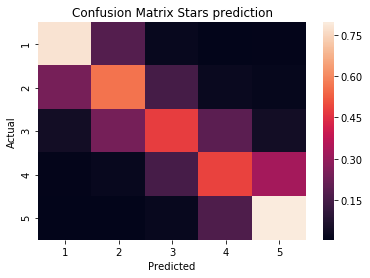

In [84]:
all_preds = np.array(all_preds)
print(all_preds.shape)
y_predictions = all_preds.argmax(axis=1)
y_true = y_test.argmax(axis=1)
y_true = y_true[:len(y_predictions)]

cm = ConfusionMatrix(y_true, y_predictions)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))

test_correctPred = np.equal(y_predictions, y_true)
test_accuracy = np.mean(test_correctPred.astype(float))

print(test_accuracy)